In [1]:
import numpy as np
import glob
import csv
from scipy.misc import imread
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import cv2
import time
from datetime import timedelta


# Creating the calibration matrix 

In [2]:
checkerboard_file_list = []
for name in glob.glob('/home/deep_cat/sdc-P4/camera_cal/calibration*'):
    checkerboard_file_list.append(name)
    
print(checkerboard_file_list)

['/home/deep_cat/sdc-P4/camera_cal/calibration7.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration18.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration17.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration4.png', '/home/deep_cat/sdc-P4/camera_cal/calibration19.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration20.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration12.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration1.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration8.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration11.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration15.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration2.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration6.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration9.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration10.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration5.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration13.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration16.jpg', '/home/deep_cat/sdc-P4/camera_cal/c

True /home/deep_cat/sdc-P4/camera_cal/calibration7.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration18.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration17.jpg
False /home/deep_cat/sdc-P4/camera_cal/calibration4.png
True /home/deep_cat/sdc-P4/camera_cal/calibration19.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration20.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration12.jpg
False /home/deep_cat/sdc-P4/camera_cal/calibration1.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration8.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration11.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration15.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration2.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration6.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration9.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration10.jpg
False /home/deep_cat/sdc-P4/camera_cal/calibration5.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration13.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration16.j

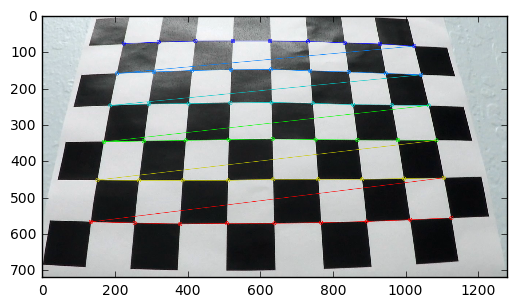

In [3]:
# this process creates the checkerboard points needed to 
# develop the calibration matrix

objpoints = []
imgpoints = []

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for path in checkerboard_file_list: 
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    print(ret, path)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)

In [4]:
# this function generates the calibration matrix needed to undistort each future image from the camera

ret, mtx,dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Image processing

In [5]:
## Gradient thresholding functions 
def abs_sobel_thresh(img, orient='x', sobel_kernel = 3, thresh=(0,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    
    scaled_sobel_x = np.uint8(255*abs_sobel_x / np.max(abs_sobel_x))
    scaled_sobel_y = np.uint8(255*abs_sobel_y / np.max(abs_sobel_y))
    
   
    
    sx_binary = np.zeros_like(scaled_sobel_x)
    sx_binary[(scaled_sobel_x >= thresh[0]) & (scaled_sobel_x <= thresh[1])] = 1  
       
    sy_binary = np.zeros_like(scaled_sobel_y)
    sy_binary[(scaled_sobel_y >= thresh[0]) & (scaled_sobel_y <= thresh[1])] = 1  
    
    if orient == 'x': 
        return sx_binary
        
    if orient == 'y':
        return sy_binary
    
    
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 6) Create a binary mask where mag thresholds are met
    # 7) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
   
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    # abs_sobel_x = np.absolute(sobel_x)
    # abs_sobel_y = np.absolute(sobel_y)
    
    # scaled_sobel_x = np.uint8(255*abs_sobel_x / np.max(abs_sobel_x))
    # scaled_sobel_y = np.uint8(255*abs_sobel_y / np.max(abs_sobel_y))
    
    magnitude = np.sqrt((sobel_x**2) + (sobel_y**2))
    scale_factor = np.max(magnitude)/255
    magnitude=  (magnitude/scale_factor).astype(np.uint8)
    
    mag_binary= np.zeros_like(magnitude)
    mag_binary[(magnitude >= mag_thresh[0]) & (magnitude <= mag_thresh[1])] = 1  
    return mag_binary


# thresholding the direction 

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    # Here I'm suppressing annoying error messages
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# color thresholding function 
def hls_select(img, thresh=(0, 255)):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    binary_output =  np.zeros_like(s)
    binary_output[(s >= thresh[0]) & (s <= thresh[1])] = 1
    return binary_output

# Image Pipeline


In [6]:
def process_image(image):
    
    #copy of orginal frame
    original = np.copy(image)
    
    # Undistort the frame
    undistort = cv2.undistort(image, mtx, dist, None, mtx)
    
    # gradients and thresholds
    ksize = 3
    sobelx_binary = abs_sobel_thresh(undistort, orient='x', sobel_kernel=ksize, thresh=(20,100))
   
    # color thresholding
    s_binary = hls_select(image, thresh = (100,255))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobelx_binary)
    combined_binary[(s_binary == 1) | (sobelx_binary == 1)] = 1

    
    
    
    return combined_binary

In [7]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
# running the pipeline on the video
output_name = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_image)
output_clip.write_videofile(output_name, audio= False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [01:17<00:00, 16.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [9]:
HTML("""
<video width="480" height="270" controls>
  <source src="{0}">
</video>
""".format(pro))